In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import h3pandas
import seaborn as sns


Analysing 44 millions of rows containing taxi ride infromation

In [6]:
df = pd.read_csv('/Users/YashChavan/Desktop/additional_work/Data/trip_data/trip_data_1.csv')
df.columns = df.columns.str.replace(' ', '')
# df2 = pd.read_csv('trip_data_2.csv')
# df2.columns = df2.columns.str.replace(' ', '')
# df3 = pd.read_csv('trip_data_3.csv')
# df3.columns = df3.columns.str.replace(' ', '')

# df = pd.concat([df1, df2, df3],axis=0)
# del df1 
# del df2
# del df3

# handling missing values
numeric_columns = ["dropoff_longitude", "dropoff_latitude"]
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Convert pickup_datetime and dropoff_datetime to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df = df.rename({'pickup_longitude': 'lng', 'pickup_latitude': 'lat'}, axis=1)
# Convert to H3 grid at resolution 11
resolution = 11
df = df.h3.geo_to_h3(resolution)

df = df.reset_index(['h3_11'] )

df['h3_index_count'] = df.groupby(['h3_11'])['h3_11'].transform('count')



Analyze trends in taxi rides over time, possibly on a daily, weekly, or monthly basis.

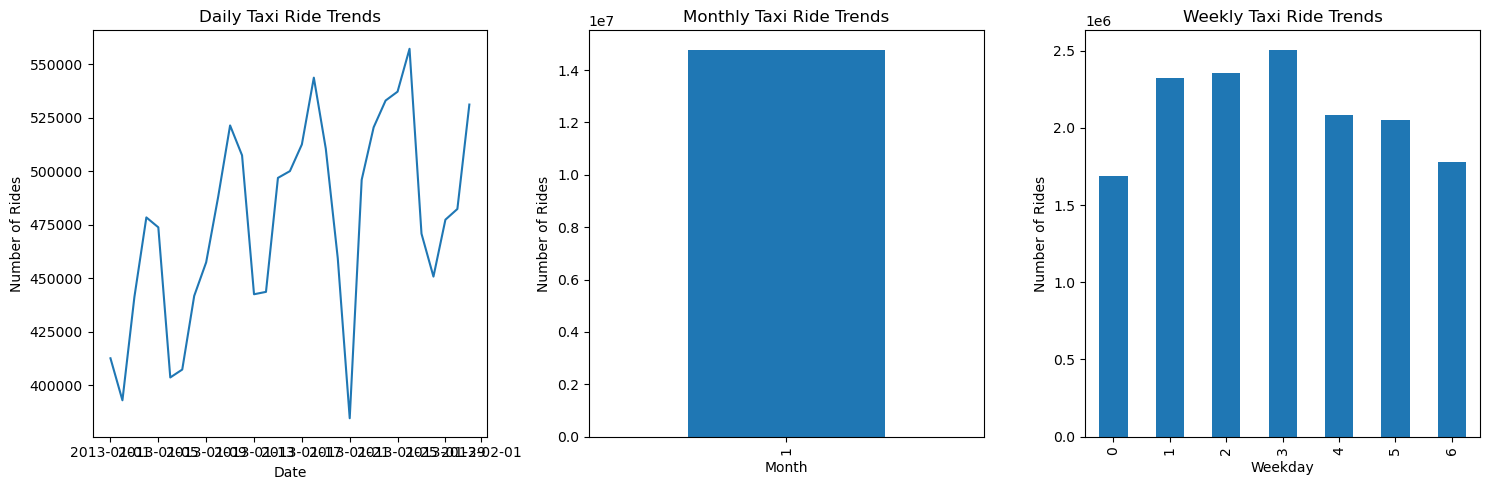

In [7]:

# Extract date-related features for analysis
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday  # Monday=0, Sunday=6

# Analyze trends on a daily basis
daily_counts = df['pickup_date'].value_counts().sort_index()

# Analyze trends on a monthly basis
monthly_counts = df['pickup_month'].value_counts().sort_index()

# Analyze trends on a weekly basis
weekly_counts = df['pickup_weekday'].value_counts().sort_index()

# Plot the trends
plt.figure(figsize=(15, 5))

plt.subplot(131)
daily_counts.plot(kind='line')
plt.title('Daily Taxi Ride Trends')
plt.xlabel('Date')
plt.ylabel('Number of Rides')

plt.subplot(132)
monthly_counts.plot(kind='bar')
plt.title('Monthly Taxi Ride Trends')
plt.xlabel('Month')
plt.ylabel('Number of Rides')

plt.subplot(133)
weekly_counts.plot(kind='bar')
plt.title('Weekly Taxi Ride Trends')
plt.xlabel('Weekday')
plt.ylabel('Number of Rides')

plt.tight_layout()
plt.show()

Investigate whether there are peak hours or days for taxi rides

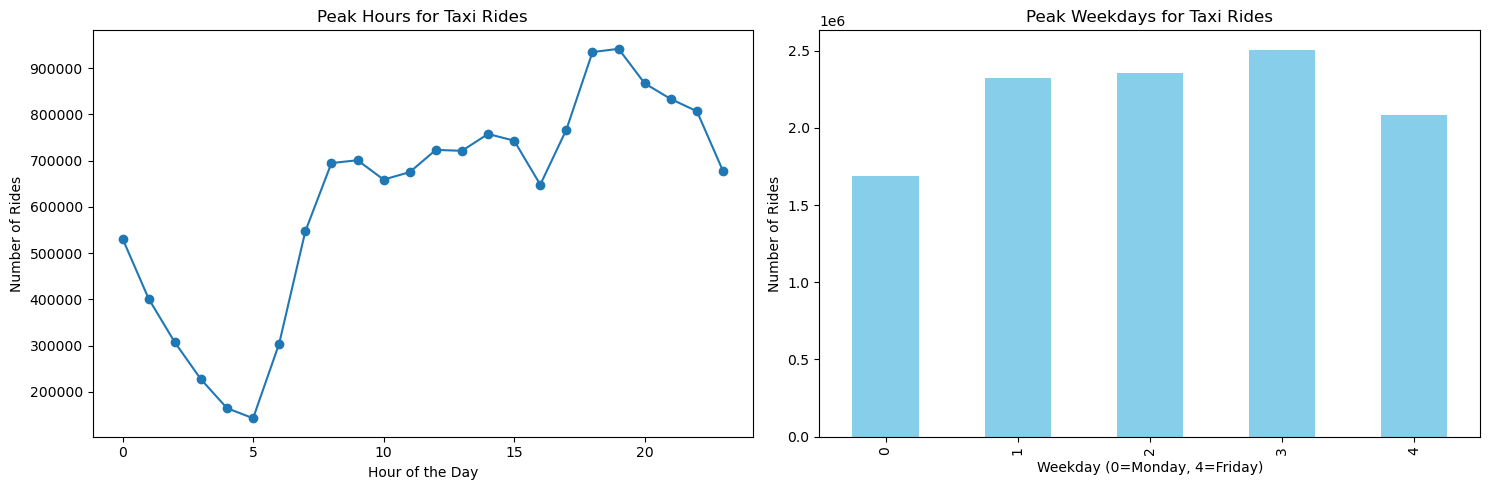

In [8]:
# Extract hour and weekday eatures
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday  # Monday=0, Sunday=6

# Analyze peak hours
hourly_counts = df['pickup_hour'].value_counts().sort_index()

# Analyze peak days (weekdays)
weekday_counts = df[df['pickup_weekday'] < 5]['pickup_weekday'].value_counts().sort_index()

# Plot the peak hour and peak weekday
plt.figure(figsize=(15, 5))

plt.subplot(121)
hourly_counts.plot(kind='line', marker='o')
plt.title('Peak Hours for Taxi Rides')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')

plt.subplot(122)
weekday_counts.plot(kind='bar', color='skyblue')
plt.title('Peak Weekdays for Taxi Rides')
plt.xlabel('Weekday (0=Monday, 4=Friday)')
plt.ylabel('Number of Rides')

plt.tight_layout()
plt.show()

Use-case 

Public Safety: Monitoring pickup and dropoff locations during late hours can help identify areas with potential safety concerns. Law enforcement agencies can use this data to deploy resources strategically.

In [9]:


# Filter the data
df_filtered = df[(df['pickup_hour'] > 1) & (df['pickup_hour'] < 5)]

# sort the data by h3_index_count
df_filtered = df_filtered.sort_values(by=['h3_index_count'], ascending=False)

# print the maximum value of the h3_index_count column and its corresponding h3_index
print("most safe region during late night is: ", df_filtered['h3_11'].iloc[0], " with count: ", df_filtered['h3_index_count'].iloc[0])

most safe region during late night is:  8b754e649929fff  with count:  264914


Comparing the performance of different taxi vendors (vendor_id) in terms of trip duration, distance, and fares

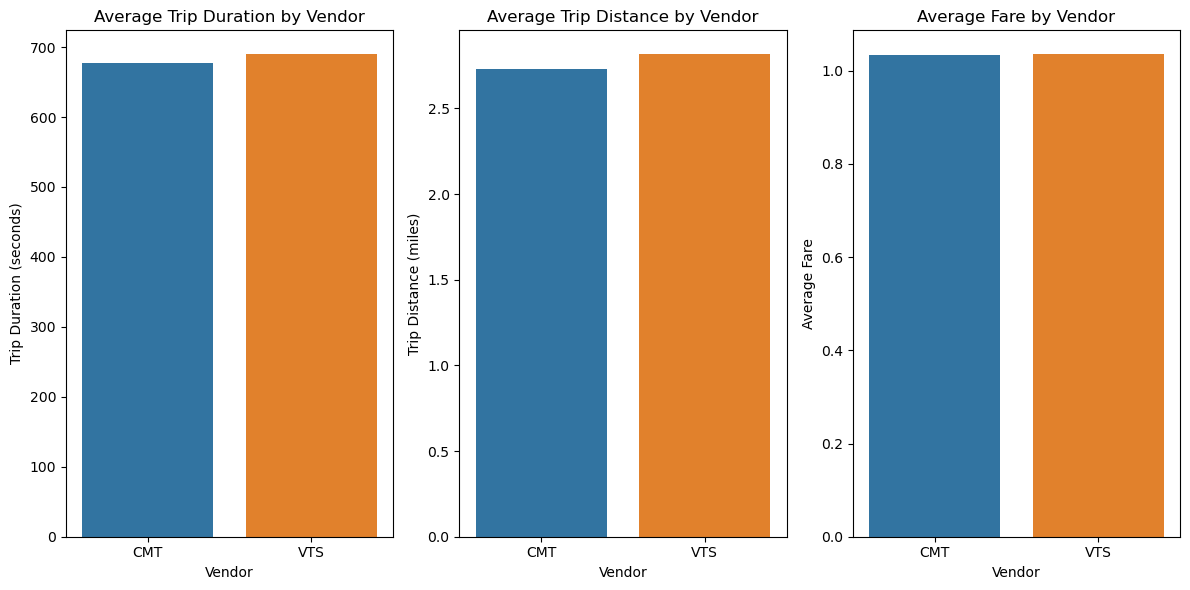

In [11]:
# Group data by vendor_id
vendor_grouped = df.groupby('vendor_id')

# Calculate mean trip duration, trip distance, and fare for each vendor
vendor_stats = vendor_grouped[['trip_time_in_secs', 'trip_distance']].mean()
vendor_stats['average_fare'] = df.groupby('vendor_id')['rate_code'].mean()

# Create bar plots to compare vendors
plt.figure(figsize=(12, 6))

# Average trip duration
plt.subplot(1, 3, 1)
sns.barplot(x=vendor_stats.index, y=vendor_stats['trip_time_in_secs'])
plt.title('Average Trip Duration by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Trip Duration (seconds)')

# Average trip distance
plt.subplot(1, 3, 2)
sns.barplot(x=vendor_stats.index, y=vendor_stats['trip_distance'])
plt.title('Average Trip Distance by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Trip Distance (miles)')

# Average fare
plt.subplot(1, 3, 3)
sns.barplot(x=vendor_stats.index, y=vendor_stats['average_fare'])
plt.title('Average Fare by Vendor')
plt.xlabel('Vendor')
plt.ylabel('Average Fare')

plt.tight_layout()
plt.show()